In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing required libraries

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import gc
import os
import warnings
import matplotlib.pyplot as plt

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


### Importing data - Unzip folders and Create train, test, val

In [5]:
data_path = "./"
import zipfile
zip_train = '../input/dogs-vs-cats-redux-kernels-edition/train.zip'
zip_test = '../input/dogs-vs-cats-redux-kernels-edition/test.zip'

# Unzipping folders
zip_train = zipfile.ZipFile(zip_train, 'r')
zip_train.extractall('all')
zip_train.close()
zip_test = zipfile.ZipFile(zip_test, 'r')
zip_test.extractall('test')
zip_test.close()

# Creating train folder
list_for_df = []
for i in os.listdir('./all/train/'):
    tmplist = []
    if i[0] == 'c':
        tmplist.append(0)
    else:
        tmplist.append(1)
    tmplist.append(i)
    list_for_df.append(tmplist)
len(list_for_df)
train_df = pd.DataFrame(data=list_for_df, columns=['class','fname'])
train_df['class'] = train_df['class'].astype('str')

# Creating test folder
list_for_df1 = []
for i in os.listdir('./test/test'):
    tmplist = []
    tmplist.append(i)
    list_for_df1.append(tmplist)
len(list_for_df1)
df_test = pd.DataFrame(data=list_for_df1, columns=['fname'])

# Creating train-validation
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(train_df)

In [8]:
print('Train: \n',df_train.head())
print(df_train.shape)
print('\nValidation: \n',df_val.head())
print(df_test.shape)
print('\nTest: \n',df_test.head())
print(df_test.shape)

Train: 
       class          fname
12428     1   dog.4795.jpg
13672     1  dog.11382.jpg
23352     1    dog.659.jpg
14054     1   dog.6111.jpg
2008      0  cat.11092.jpg
(18750, 2)

Validation: 
       class          fname
10267     1   dog.3581.jpg
16951     1   dog.1717.jpg
12389     1  dog.11183.jpg
14774     0    cat.848.jpg
24508     0  cat.11572.jpg
(12500, 1)

Test: 
       fname
0  1552.jpg
1  8096.jpg
2  7021.jpg
3  3908.jpg
4  5694.jpg
(12500, 1)


### Image Augmentation using Data Generator

In [9]:
from keras.preprocessing.image import ImageDataGenerator

img_size = (256,256)
nb_train_samples = len(df_train)
nb_validation_samples = len(df_val)
nb_test_samples = len(df_test)
batch_size = 8

# Define Image Data Generator configuration
train_datagen = ImageDataGenerator(
  horizontal_flip = True,
  vertical_flip = False,
  zoom_range = 0.10,
  rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

original_dataset_dir = './all/train'

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = original_dataset_dir,
    x_col = 'fname',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    seed = 42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory = original_dataset_dir,
    x_col = 'fname',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False
)

test_data_path = './test/test'

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = test_data_path,
    x_col = 'fname',
    y_col = None,
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = None,
    batch_size = batch_size,
    shuffle = False
)

# Reference: https://www.kaggle.com/code/kkongee/xception-dog-cat-logistic

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### Model Creation - Xception

In [10]:
base_model = keras.applications.Xception(
    weights="imagenet",  
    input_shape=(256, 256, 3),
    include_top=False,)  

base_model.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

2022-05-21 00:38:36.936428: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 21,386,281
Trainable params: 524,801
Non-tr

### Fitting the model

In [11]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

epochs = 1
history=model.fit(train_generator, epochs=epochs, validation_data=validation_generator).history

2022-05-21 00:39:19.454462: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2344/2344 [==============================] - 2907s 1s/step - loss: 0.0511 - acc: 0.9846 - val_loss: 0.0272 - val_acc: 0.9899


In [12]:
steps = len(df_test) // batch_size + 1

### Checking Predictions

In [13]:
mypred = model.predict_generator(
    test_generator, steps = steps)

In [14]:
mypred_val = mypred
mypred_val.shape

(12500, 1)

In [15]:
id_val = df_test['fname'].str.split(".").str[0].values

In [16]:
np.shape(id_val)

(12500,)

In [17]:
# Only checking for a subset of data
sptl = df_test['fname'][:30].values

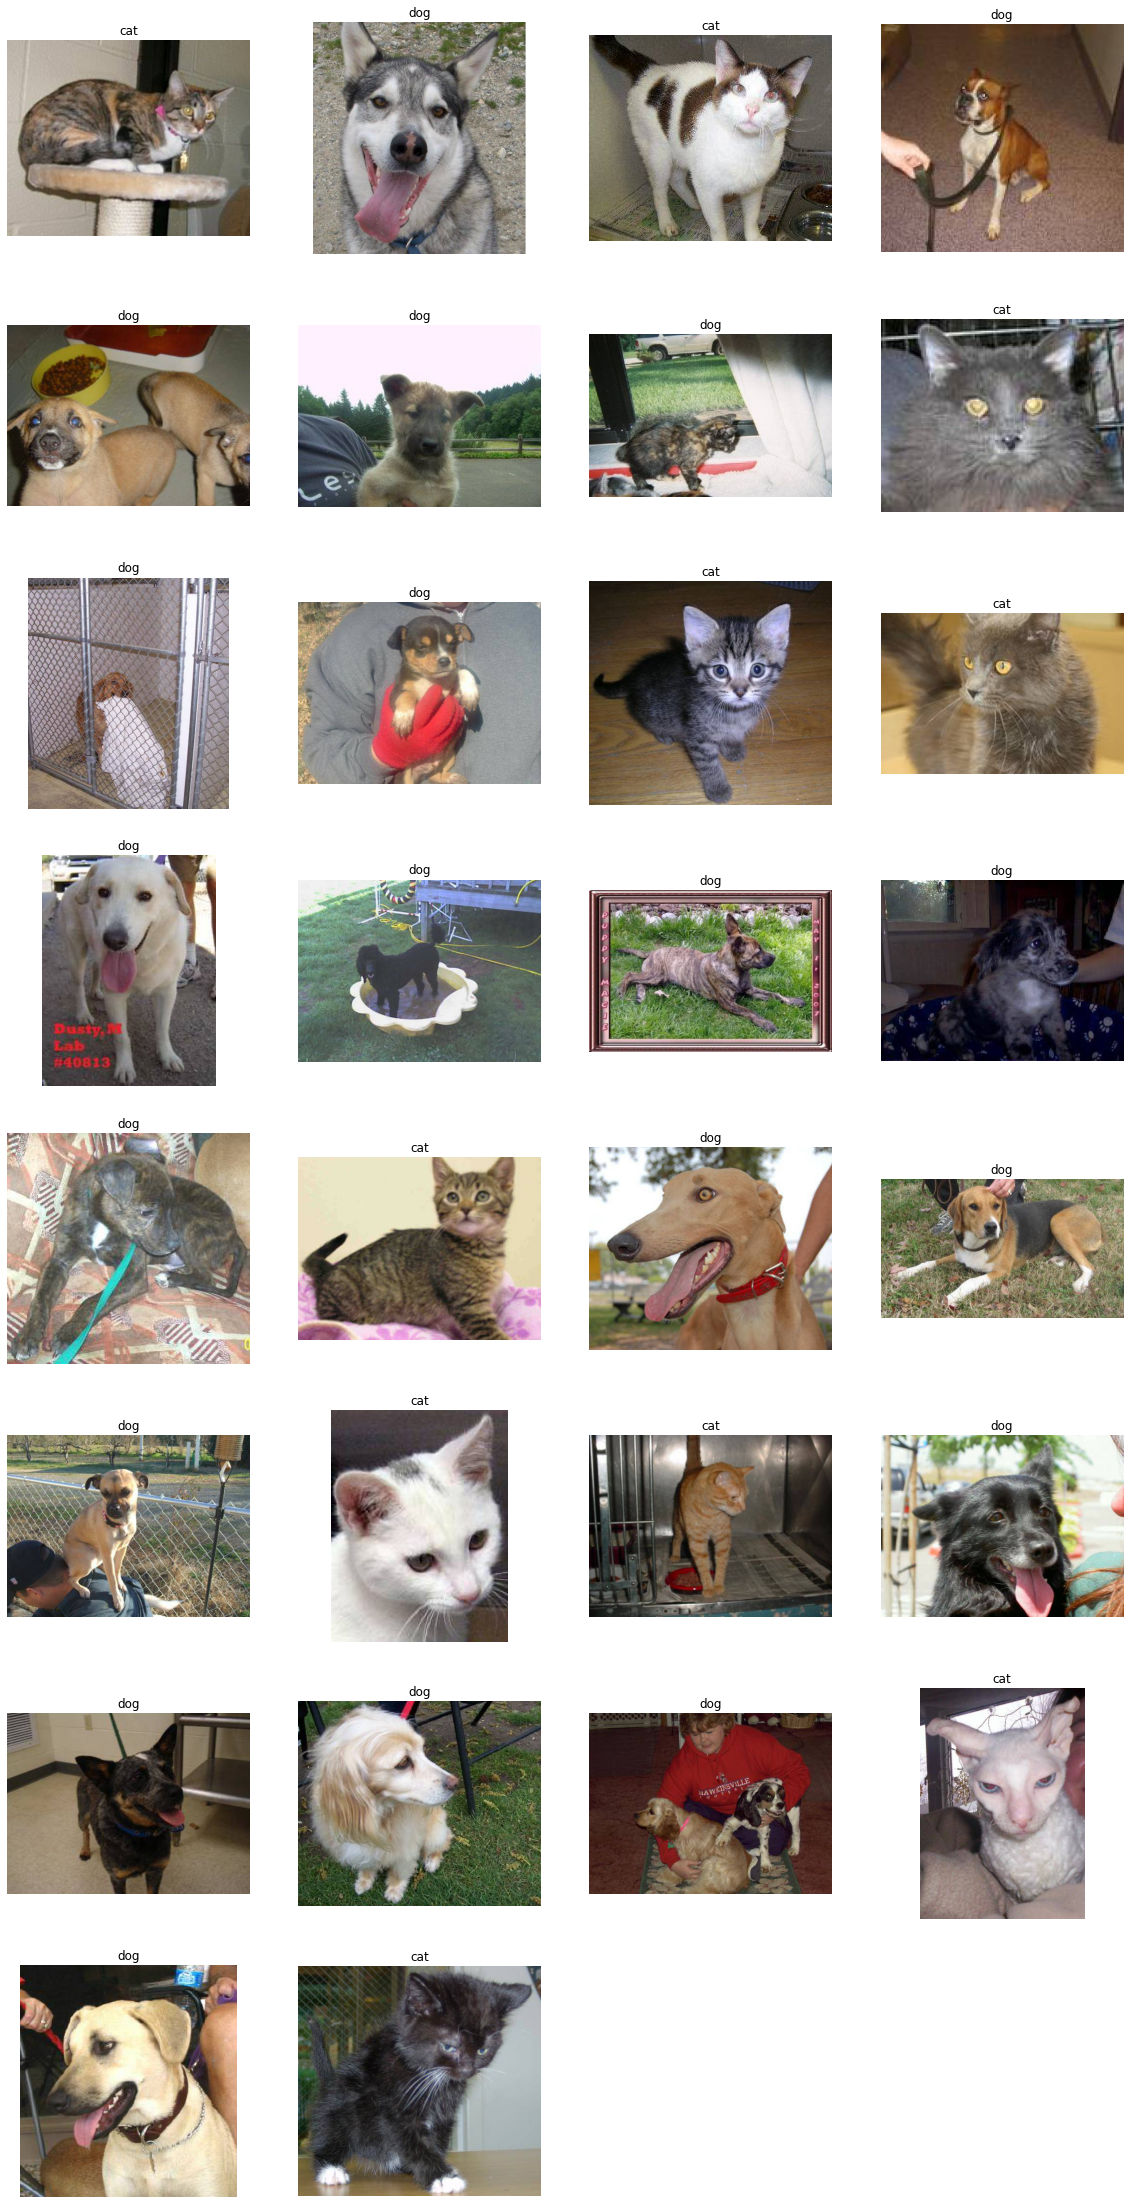

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,40))

testdir = './test/test'

import PIL

num = 0

for fname in sptl:
  img = PIL.Image.open(os.path.join(testdir, fname))
  plt.subplot(8,4,num+1)
  if mypred_val[num]<0.5:
    plt.title('cat')
  else:
    plt.title('dog')
  plt.axis('off')
  plt.imshow(img)
  num += 1

# Reference: https://www.kaggle.com/code/kkongee/xception-dog-cat-logistic

### Creating dataframe with Image ID and Predictions

In [19]:
submission = pd.DataFrame()
submission['id'] = id_val
submission['label'] = mypred_val

In [20]:
my_submission = submission.set_index('id')

### Converting to CSV - Submission file for Kaggle

In [ ]:
my_submission.to_csv("MSBA.Session1.RiyaKhurana.csv")